# ARMA Order Estimation

After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. Of course you could just try some different combinations of terms and see what works best. But there is a more systematic way to do this. By looking at the **autocorrelation function (ACF)** and **partial autocorrelation (PACF)** plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed.

## Partial Autocorrelation Function (PACF)

*Additional correlation explained by each successive lagged term.* The correlation between observations at two time steps given that we consider both observations are correlated to observations at other time spots. The key difference w.r.t. ACF is the exclusion of indirect correlations in the calculation.

We will be using the [plot_pacf](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.pacf.html) function from the statsmodels.graphics.tsaplots library with the parameter method = "ols" (regression of time series on lags of it and on constant).

The PACF plot can provide answers to the following questions:

- Can the observed time series be modeled with an **AR** model? If yes, what is the order?

## Autocorrelation Function (ACF)

*Correlation between time series with a lagged version of itself.* The correlation between the observation at the current time spot and the observations at previous time spots.The autocorrelation function starts a lag 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.

We will be using the [plot_acf](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acf.html) function from the statsmodels.graphics.tsaplots library.

Notably, the ACF plot can provide answers to the following main questions:

- Is the observed time series white noise / random?
- Is an observation related to an adjacent observation, an observation twice-removed, and so on?
- Can the observed time series be modeled with an **MA** model? If yes, what is the order?

In [1]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

Both the ACF and PACF start with a **lag of 0**, which is the correlation of the time series with itself and therefore results in a **correlation of 1**.

Furthermore, you will see a **blue area** in the ACF and PACF plots, which depicts the 95% confidence interval and is in indicator for the **significance threshold**. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

### Order of AR, MA, and ARMA Model

|       | AR(*p*)        | MA(*q*)  | ARMA(*p,q*)  |
|------|-----------|-----------|------|
|ACF    | Tails off (Geometric decay)      | Significant at lag *q* / Cuts off after lag *q* |Tails off (Geometric decay)|
|PACF   | Significant at each lag *p* / Cuts off after lag *p* | Tails off (Geometric decay)|Tails off (Geometric decay) |

In [2]:
import numpy as np
from numpy.random import seed 
import math 
import pandas as pd
from datetime import datetime, date 

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import seaborn as sns

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

import statsmodels as sm

# Fix seed for reproducible results
SEED = 42
np.random.seed(SEED)

# Visualizations
lag_acf = 15
lag_pacf = 15
height = 4
width = 12

Let's see some examples:

### AR(1) Process

The following time series is an AR(1) process with 512 timesteps and the following parameters:

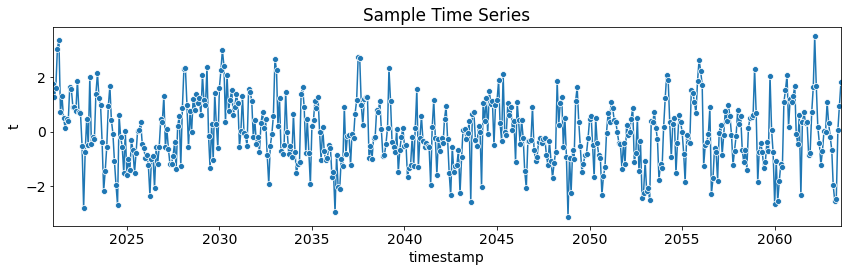

In [3]:
alpha_1 = 0.5 # parameter of the AR(1) process

num_samples =  512

np.random.seed(0)
ar = np.r_[1, -np.array([alpha_1])] # add zero-lag and negate
ma = np.r_[1] # add zero-lag

sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=num_samples, freq='MS'),
                       't' : sm.tsa.arima_process.arma_generate_sample(ar, ma, num_samples)
                      })

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

#### Check ACF and PACF

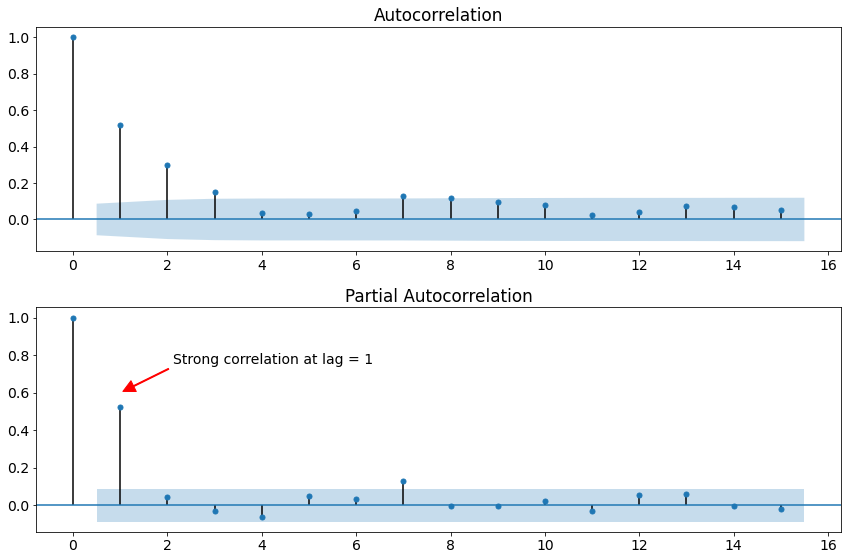

In [4]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(sample['t'],lags=lag_acf, ax=ax[0])
plot_pacf(sample['t'],lags=lag_pacf, ax=ax[1], method='ols')

ax[1].annotate('Strong correlation at lag = 1', xy=(1, 0.6),  xycoords='data',
            xytext=(0.17, 0.75), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))

plt.tight_layout()
plt.show()

We can make the following observations:

- There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.
- High degree of autocorrelation between adjacent (lag = 1)

#### Build the model

Thus, we can use an **AR(1) model** to model this process.

In this case we will use the more general approach, called SARIMA.

Be aware that there exists also the [AutoReg](https://www.statsmodels.org/devel/generated/statsmodels.tsa.ar_model.AutoReg.html) for the AR and the [ARIMA](https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html) python objects.

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [6]:
train_len = int(0.8* num_samples)

train = sample['t'][:train_len]
ar_model = SARIMAX(train, order=(1,0,0)).fit()

print(ar_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      t   No. Observations:                  409
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -574.009
Date:                Thu, 16 Nov 2023   AIC                           1152.017
Time:                        01:14:14   BIC                           1160.045
Sample:                             0   HQIC                          1155.194
                                - 409                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5164      0.042     12.389      0.000       0.435       0.598
sigma2         0.9687      0.073     13.227      0.000       0.825       1.112
Ljung-Box (L1) (Q):                   0.78   Jarque-

As you can see, the AR(1) model fits an $\alpha_1 = 0.5167$ , which is quite close to the alpha_1 = 0.5 which we have set. However, the predicted values seem to be quite off in this case.

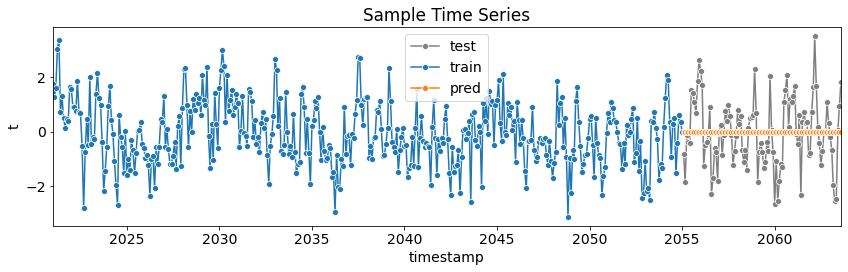

In [7]:
pred = ar_model.predict(start=train_len, end=num_samples, dynamic=False)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.lineplot(x=sample.timestamp[train_len:num_samples], y=sample.t[train_len:num_samples], marker='o', label='test', color='grey')
sns.lineplot(x=sample.timestamp[:train_len], y=train, marker='o', label='train')
sns.lineplot(x=sample.timestamp[train_len:num_samples], y=pred, marker='o', label='pred')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

We can note that the prediction flatlines very quickly past the train data. There is nothing wrong in this behaviour. Indeed, that's the behavior of a stationary ARMA process where predictions converge to the mean.

#### Model diagnostic

After fitting the model, a very important phase is the **model diagnostic**, where we inspect the residuals coming from the model. To do so, we can just call the *plot_diagnostics* function that already output all the information that we want to inspect.

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the model does not satisfy these properties, it is a good indication that it can be further improved.

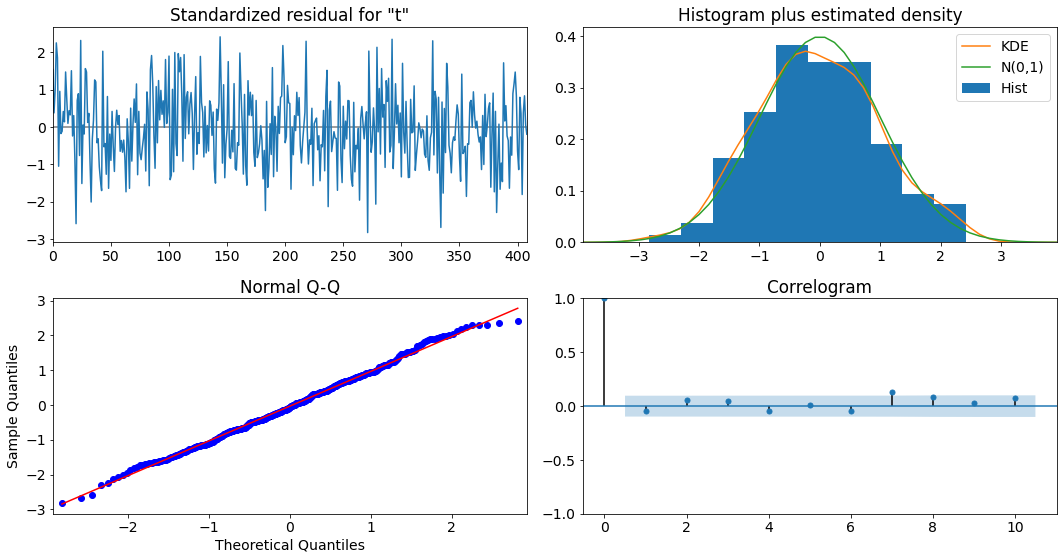

In [8]:
ar_model.plot_diagnostics(figsize=(15,8))
plt.tight_layout()
plt.show()

When looking at these 4 plots, we need to assess whether our model is good or not.

Here is a reminder of what you would like to see in each of the plots for a model that fits well:

<div style="text-align: center; line-height: 0; padding-top: 25px;">
      <img src="images/plot_diagnostics.png" alt="Plot diagnostics" style="width: 550px; height: 400px">
</div>

In this case, the model diagnostic suggests that the model residual is normally distributed based on the following:

- In the top right plot, the orange KDE line follows closely with the N(0,1) line. Where, N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation of 1. This is a good indication that the residuals are normally distributed.
- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution. Again, this is a strong indication that the residuals are normally distributed.
- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise.
- This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

### MA(1) Process

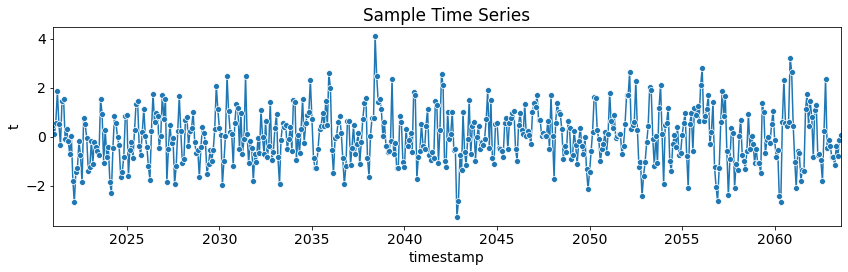

In [9]:
beta_1 = 0.5 # parameter of the MA(1) process

np.random.seed(SEED)
ar = np.r_[1] # add zero-lag and negate
ma = np.r_[1, np.array([beta_1])] # add zero-lag

sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=num_samples, freq='MS'),
                       't' : sm.tsa.arima_process.arma_generate_sample(ar, ma, num_samples)
                      })

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

#### Check ACF and PACF

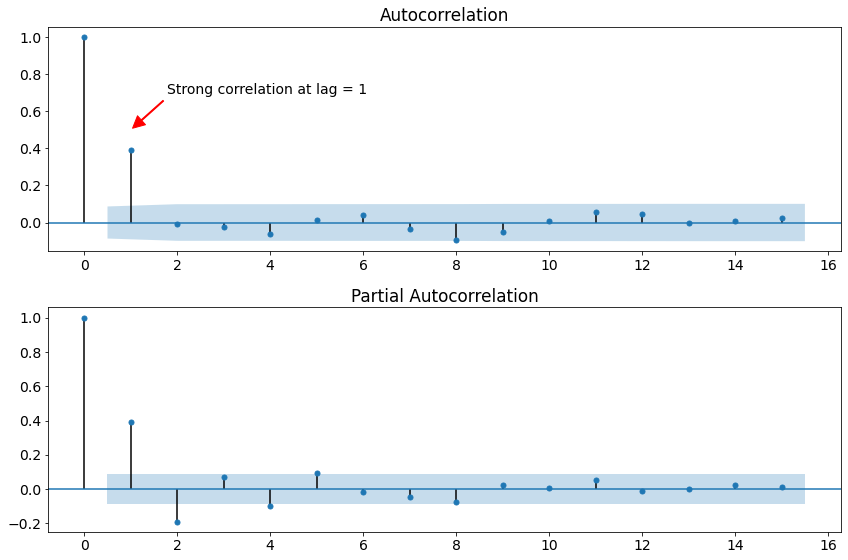

In [10]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(sample['t'],lags=lag_acf, ax=ax[0])
plot_pacf(sample['t'],lags=lag_pacf, ax=ax[1], method='ols')

ax[0].annotate('Strong correlation at lag = 1', xy=(1, 0.5),  xycoords='data',
            xytext=(0.15, 0.7), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))

plt.tight_layout()
plt.show()

We can make the following observations:

- There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.
- High degree of autocorrelation between adjacent (lag = 1)

#### Build the model

Thus, we can use an **MA(1) model** to model this process.

In [11]:
train_len = int(0.8* num_samples)

train = sample['t'][:train_len]
ma_model = SARIMAX(train, order=(0,0,1)).fit()

print(ma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      t   No. Observations:                  409
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -561.275
Date:                Thu, 16 Nov 2023   AIC                           1126.550
Time:                        01:14:15   BIC                           1134.578
Sample:                             0   HQIC                          1129.726
                                - 409                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4676      0.044     10.546      0.000       0.381       0.555
sigma2         0.9104      0.058     15.779      0.000       0.797       1.023
Ljung-Box (L1) (Q):                   0.17   Jarque-

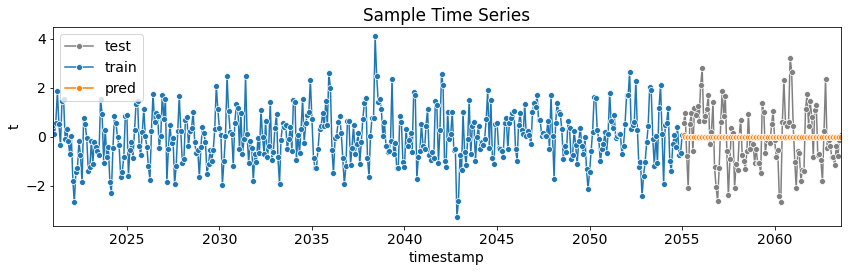

In [12]:
pred = ma_model.predict(start=train_len, end=num_samples, dynamic=False)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.lineplot(x=sample.timestamp[train_len:num_samples], y=sample.t[train_len:num_samples], marker='o', label='test', color='grey')
sns.lineplot(x=sample.timestamp[:train_len], y=train, marker='o', label='train')
sns.lineplot(x=sample.timestamp[train_len:num_samples], y=pred, marker='o', label='pred')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

#### Model diagnostic

After fitting the model, we proceed with the **model diagnostic** phase:

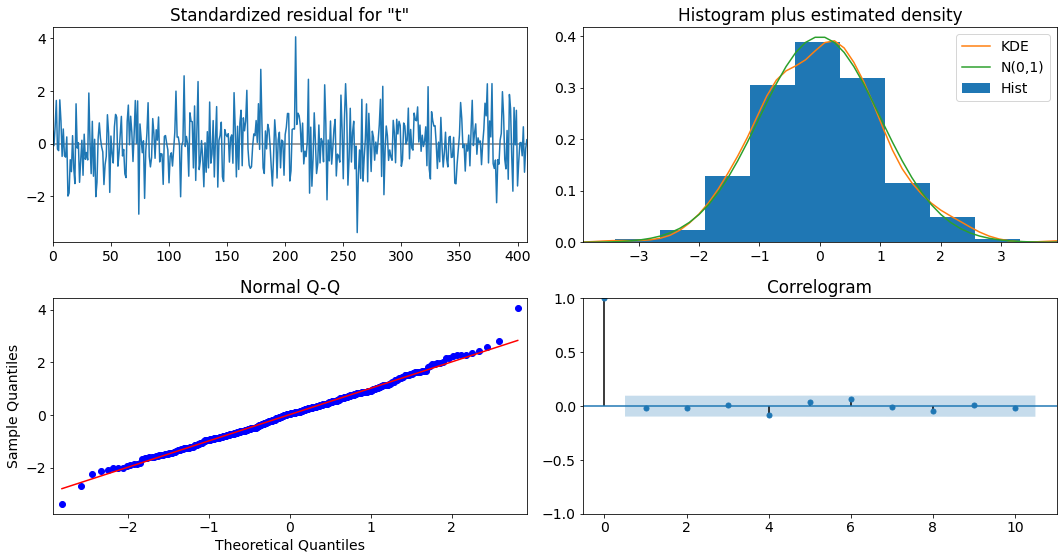

In [13]:
ma_model.plot_diagnostics(figsize=(15,8))
plt.tight_layout()
plt.show()

## Beyond ACF and PACF, how to choose the best p and/or q for the AR/MA/ARMA/ARIMA/SARIMA model?

In finding the best model, we can rely also on the so-called *information criteria*, e.g., AIC, BIC, and HQIC. Notably, *good models are obtained by minimising the AIC, BIC or HQIC.*

[Here](https://otexts.com/fpp2/arima-estimation.html) you can find more information about the information criteria.

Let's try to iterate over multiple combinations of *p* and *q* values to see for the last case (data generated by a MA(1) process) which model obtains the best results. We can directly access the BIC and AIC values from the results output by the fit method:

In [14]:
order_aic_bic =[]

# Loop over AR order
for p in range(3):
    # Loop over MA order 
    for q in range(3):
        # Fit model
        results = SARIMAX(train, order=(p,0,q)).fit()
        # print the model order and the AIC/BIC values
        print(p, q, results.aic, results.bic)
        # Add order and scores to list
        order_aic_bic.append((p, q, results.aic, results.bic))

0 0 1198.7984274428422 1202.812142598885
0 1 1126.5501503754645 1134.5775806875502
0 2 1127.6733300328328 1139.7144755009613
1 0 1143.7943432030615 1151.8217735151472
1 1 1127.542254753149 1139.5834002212775
1 2 1129.0476261709825 1145.1024867951537
2 0 1132.8444754644386 1144.885620932567
2 1 1129.0944930663186 1145.1493536904898
2 2 1130.9950463441612 1151.0636221243751


In [15]:
# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p','q', 'aic', 'bic'])

In [16]:
# Sort by AIC
print(order_df.sort_values('aic'))

   p  q          aic          bic
1  0  1  1126.550150  1134.577581
4  1  1  1127.542255  1139.583400
2  0  2  1127.673330  1139.714476
5  1  2  1129.047626  1145.102487
7  2  1  1129.094493  1145.149354
8  2  2  1130.995046  1151.063622
6  2  0  1132.844475  1144.885621
3  1  0  1143.794343  1151.821774
0  0  0  1198.798427  1202.812143


In [17]:
# Sort by BIC
print(order_df.sort_values('bic'))

   p  q          aic          bic
1  0  1  1126.550150  1134.577581
4  1  1  1127.542255  1139.583400
2  0  2  1127.673330  1139.714476
6  2  0  1132.844475  1144.885621
5  1  2  1129.047626  1145.102487
7  2  1  1129.094493  1145.149354
8  2  2  1130.995046  1151.063622
3  1  0  1143.794343  1151.821774
0  0  0  1198.798427  1202.812143


We can see that in this case we would end up using MA(1) with both AIC and BIC.

We can also do the whole process automatically, by applying the [auto-arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) function.

Here you can find [Tips to using Auto-ARIMA](https://www.alkaline-ml.com/pmdarima/tips_and_tricks.html).

In [18]:
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1132.889, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1200.622, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1145.706, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1128.446, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1198.798, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1129.430, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1129.561, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1130.939, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1126.550, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1127.542, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1127.673, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1143.794, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1129.048, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.365 seconds


ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

#### Reference material

- [Time Series: Interpreting ACF and PACF](https://www.kaggle.com/iamleonie/time-series-interpreting-acf-and-pacf)